In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from scipy import ndimage
from scipy.ndimage import zoom
import torch.nn.functional as F # change

config = {
    'learning_rate': 1e-4,
    'lr_decay_rate': 0.96,
    'epochs': 100,
    'batch_size': 4,
    'img_size': 128,
    'depth': 64
}


In [3]:

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:6


In [4]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min_hu = -1000
    max_hu = 400
    volume[volume < min_hu] = min_hu
    volume[volume > max_hu] = max_hu
    volume = (volume - min_hu) / (max_hu - min_hu)
    return volume.astype('float32')

def resize_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]
    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path, is_mask_file = False):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume) if not is_mask_file else volume
    # Resize width, height and depth
    volume = resize_volume(
        volume, config['img_size'], config['img_size'], config['depth']
    )
    return volume


In [5]:
# Create directories
output_dir = os.path.join(os.getcwd(), "MosMedData")
os.makedirs(output_dir, exist_ok=True)

test_scan_paths = [os.path.join(output_dir, "CT-1", x) for x in sorted(os.listdir(os.path.join(output_dir, "CT-1")))]
mask_scan_paths = [os.path.join(output_dir, "mask", x) for x in sorted(os.listdir(os.path.join(output_dir, "mask")))]


print("CT scans: " + str(len(test_scan_paths)), test_scan_paths, mask_scan_paths )

CT scans: 6 ['/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/CT-1/study_0255.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/CT-1/study_0256.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/CT-1/study_0257.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/CT-1/study_0258.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/CT-1/study_0259.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/CT-1/study_0260.nii.gz'] ['/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/mask/study_0255_mask.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/mask/study_0256_mask.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/mask/study_0257_mask.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/mask/study_0258_mask.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/mask/study_0259_mask.nii.gz', '/local/scratch/v_neelesh_bisht/3d-cnn/MosMedData/mask/study_0260_mask.nii.gz']


In [6]:
x_test = np.array([process_scan(path) for path in test_scan_paths])
y_test = np.array([1 for _ in range(len(test_scan_paths))])

print(
    'Number of samples in test are %d'
    % (x_test.shape[0])
)
mask_to_test = mask_scan_paths[0]
test_sample = x_test[0] # width, height, depth
test_tensor = torch.tensor(test_sample).permute(2, 0 ,1) # depth, width, height
print(test_tensor.shape)

Number of samples in test are 6
torch.Size([64, 128, 128])


In [7]:
class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(Conv3DBlock, self).__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, padding=1)
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool3d(2)
        self.batchnorm = nn.BatchNorm3d(out_channels)

    def forward(self, x):
        x = self.conv3d(x)
        x = self.activation(x)
        x = self.pool(x)
        x = self.batchnorm(x)
        return x

class CNN3D(nn.Module):
    def __init__(self, width=128, height=128, depth=64):
        super(CNN3D, self).__init__()
        self.conv1 = Conv3DBlock(1, 64)
        self.conv2 = Conv3DBlock(64, 64)
        self.conv3 = Conv3DBlock(64, 128)
        self.conv4 = Conv3DBlock(128, 256)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(128, 2) # number of classes: 2 


    def forward(self, x):
        features_blobs = []
        x = self.conv1(x)
        features_blobs.append(x)
        x = self.conv2(x)
        features_blobs.append(x)
        x = self.conv3(x)
        features_blobs.append(x)
        x = self.conv4(x)
        features_blobs.append(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x, features_blobs

# Build model
model = CNN3D().to(device)
print(model)


CNN3D(
  (conv1): Conv3DBlock(
    (conv3d): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv3DBlock(
    (conv3d): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Conv3DBlock(
    (conv3d): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (activation): ReLU()
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Con

In [8]:
model.load_state_dict(torch.load("3d_cnn_image_classification.pth"))
model.eval()

with torch.no_grad():
    sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
    prediction, _ = model(sample)
    print(prediction, prediction.shape) # change
    softmaxed_prediction = F.softmax(prediction, dim=1) # change
    scores = softmaxed_prediction.squeeze().cpu().numpy() # change
    print(scores) # change

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {score * 100:.2f} percent confident that CT scan is {name}")

tensor([[-0.4243,  0.4085]], device='cuda:6') torch.Size([1, 2])
[0.30304375 0.6969563 ]
This model is 30.30 percent confident that CT scan is normal
This model is 69.70 percent confident that CT scan is abnormal


## Diff-Grad-CAM starts here

In [16]:
import torch
import torch.nn.functional as F
import numpy as np

def compute_gradcam_weights(gradients):
    # Compute the weights
    pooled_grads = np.mean(gradients, axis=(0, 2, 3))
    return pooled_grads

def get_activations_and_gradients(img_tensor, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a hook to store the activations and gradients
    activations = {}
    gradients = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activations['conv4'] = output
        return hook
    
    def get_gradients(name):
        def hook(module, grad_in, grad_out):
            gradients['conv4'] = grad_out[0]
        return hook
    
    # Register hooks to capture activations and gradients
    last_conv_layer = dict(model.named_modules())[last_conv_layer_name]

    hook_handles = [
        last_conv_layer.register_forward_hook(get_activation(last_conv_layer_name)),
        last_conv_layer.register_backward_hook(get_gradients(last_conv_layer_name))
    ]
    
    # Make a forward pass to get predictions and activations
    model.eval()
    output, _ = model(img_tensor)
    
    if pred_index is None:
        pred_index = torch.argmax(output, dim=1)
    class_output = output[:, pred_index].squeeze()

    # Backward pass to get gradients
    model.zero_grad()
    class_output.backward(retain_graph=True)
    
    # Get the captured gradients and activations
    activations = activations[last_conv_layer_name].detach().cpu().numpy()
    gradients = gradients[last_conv_layer_name].detach().cpu().numpy()

    # Remove hooks
    for handle in hook_handles:
        handle.remove()
    return activations, gradients

def make_gradcam_heatmap(activations, weights):
    # Compute the heatmap
    activation_ = activations.copy()
    for i in range(weights.shape[0]):
        activation_[:, i, :, :] *= weights[i]
    heatmap = np.mean(activation_, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) # depth, width, height
    heatmap = np.transpose(heatmap, (1, 2, 0)) # width, height, depth
    print("heatmap", heatmap.shape )
    return heatmap


last_conv_layer_name = 'conv4'
sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

target_class_idx = 1  # Target class
ref_class_idx = 0  # Reference class

# Get activations and gradients for target and reference class
activations, target_class_gradients = get_activations_and_gradients(sample, model, last_conv_layer_name, pred_index=target_class_idx)
ref_class_activations, ref_class_gradients = get_activations_and_gradients(sample, model, last_conv_layer_name, pred_index=ref_class_idx)

#Compute gradient weights from the gradients.
target_class_weights = compute_gradcam_weights(target_class_gradients)
ref_class_weights = compute_gradcam_weights(ref_class_gradients)

####### Compute the differential weights
diff_weights = target_class_weights - ref_class_weights
print("weights: are equal",np.array_equal(diff_weights, target_class_weights))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(activations, diff_weights)
target_class_heatmap = make_gradcam_heatmap(activations, target_class_weights)
ref_class_heatmap = make_gradcam_heatmap(activations, ref_class_weights)
print("heatmap are equal: ",np.array_equal(heatmap, target_class_heatmap))
print("heatmap generated")

weights: are equal False
heatmap (8, 8, 4)
heatmap (8, 8, 4)
heatmap (8, 8, 4)
heatmap are equal:  False
heatmap generated


Heatmap min: 0.0 max: 1.0
Target class heatmap min: 0.0 max: 1.0


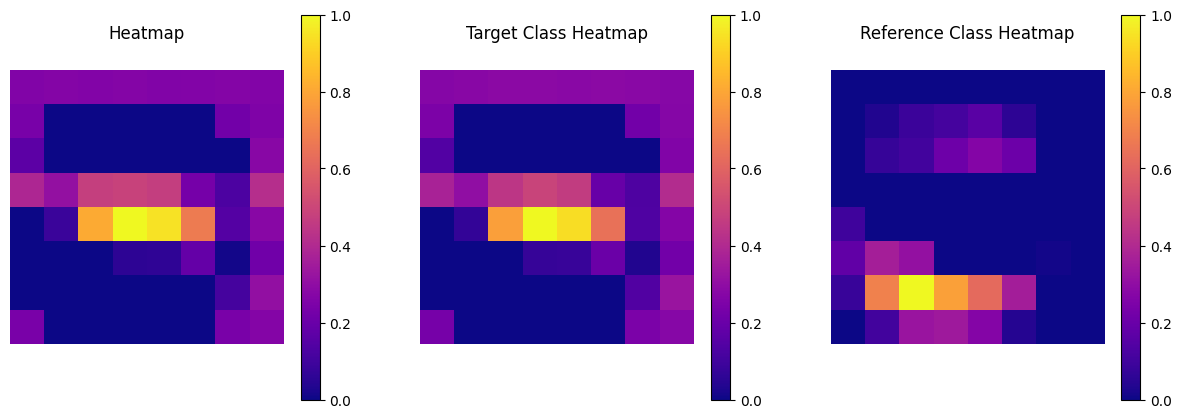

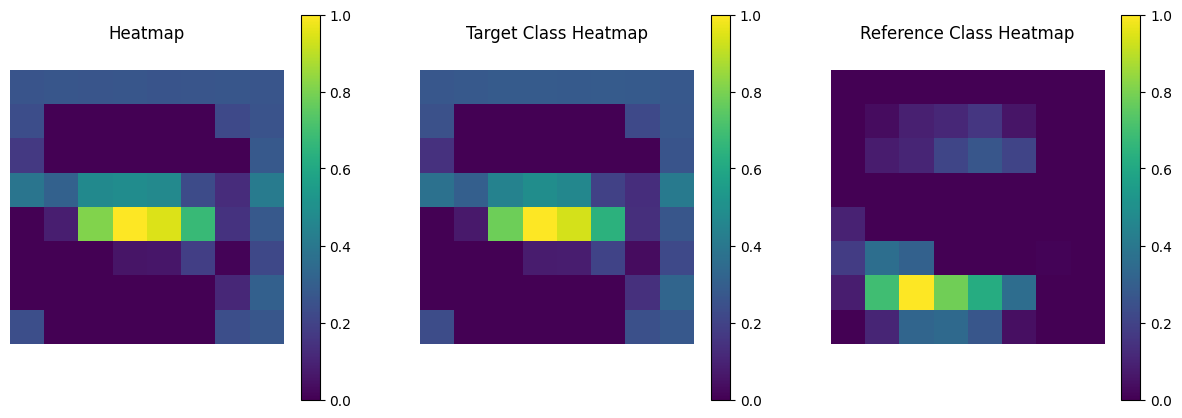

0.26082045 0.2723291
0.3869709 0.37242493
0.0 0.0


In [10]:
# plt.matshow(np.squeeze(heatmap[:, :, 3]))
# plt.show()
# plt.matshow(np.squeeze(target_class_heatmap[:, :, 3]))
# plt.show()
# plt.matshow(np.squeeze(ref_class_heatmap[:, :, 3]))
# plt.show()

print("Heatmap min:", np.min(heatmap), "max:", np.max(heatmap))
print("Target class heatmap min:", np.min(target_class_heatmap), "max:", np.max(target_class_heatmap))

# Normalize both heatmaps to [0, 1] range
heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
target_class_heatmap_normalized = (target_class_heatmap - np.min(target_class_heatmap)) / (np.max(target_class_heatmap) - np.min(target_class_heatmap))
ref_class_heatmap_normalized = (ref_class_heatmap - np.min(ref_class_heatmap)) / (np.max(ref_class_heatmap) - np.min(ref_class_heatmap))

# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot each heatmap in a subplot
cax1 = axs[0].matshow(np.squeeze(heatmap[:, :, 3]), cmap='plasma')
axs[0].set_title('Heatmap')
fig.colorbar(cax1, ax=axs[0])

cax2 = axs[1].matshow(np.squeeze(target_class_heatmap[:, :, 3]), cmap='plasma')
axs[1].set_title('Target Class Heatmap')
fig.colorbar(cax2, ax=axs[1])

cax3 = axs[2].matshow(np.squeeze(ref_class_heatmap[:, :, 3]), cmap='plasma')
axs[2].set_title('Reference Class Heatmap')
fig.colorbar(cax3, ax=axs[2])

# Remove the axis labels for a cleaner look
for ax in axs:
    ax.axis('off')

# Show the plot
plt.show()

# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))




# Plot each normalized heatmap in a subplot
cax1 = axs[0].matshow(np.squeeze(heatmap_normalized[:, :, 3]))
axs[0].set_title('Heatmap')
fig.colorbar(cax1, ax=axs[0])

cax2 = axs[1].matshow(np.squeeze(target_class_heatmap_normalized[:, :, 3]))
axs[1].set_title('Target Class Heatmap')
fig.colorbar(cax2, ax=axs[1])

cax3 = axs[2].matshow(np.squeeze(ref_class_heatmap_normalized[:, :, 3]))
axs[2].set_title('Reference Class Heatmap')
fig.colorbar(cax3, ax=axs[2])

# Remove the axis labels for a cleaner look
for ax in axs:
    ax.axis('off')

# Show the plot
plt.show()


print(heatmap_normalized[0,0,3], target_class_heatmap_normalized[0,0,3])
print(heatmap_normalized[3,0,3], target_class_heatmap_normalized[3,0,3])
print(heatmap_normalized[4,0,3], target_class_heatmap_normalized[4,0,3])

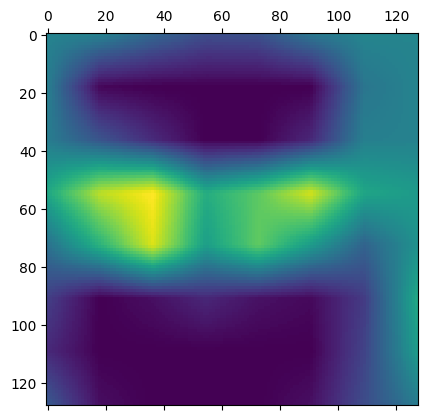

In [11]:
# Resize heatmap

def get_resized_heatmap(heatmap, shape):
    width = shape[0]
    height = shape[1]
    depth = shape[2]
    upscaled_heatmap = zoom(heatmap, (width / heatmap.shape[0], height / heatmap.shape[1], depth / heatmap.shape[2]), order=1)
    upscaled_heatmap = np.uint8(255 * upscaled_heatmap)
    return upscaled_heatmap

resized_heatmap = get_resized_heatmap(heatmap, test_sample.shape)
plt.matshow(np.squeeze(resized_heatmap[:, :, 30]))
plt.show()

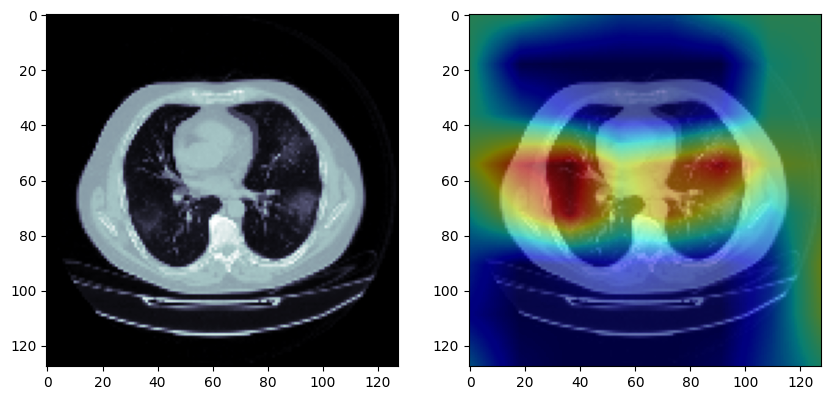

In [12]:
# Visualize heatmap
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(test_sample[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(test_sample[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]), cmap='jet', alpha=0.5, extent=img0.get_extent())
# plt.colorbar()
plt.show()


In [13]:
def read_mask_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def resize_mask_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]

    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90,  axes=(0, 1), reshape=False) # TODO why ??

    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img


mask_test_volume = read_mask_nifti_file(mask_to_test)
mask_test_volume = resize_mask_volume(mask_test_volume, config['img_size'], config['img_size'], config['depth'])

8092 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]


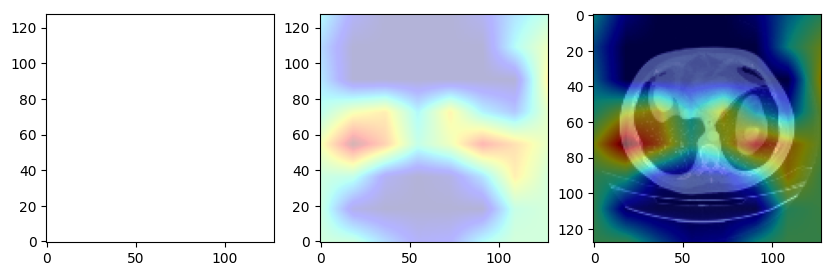

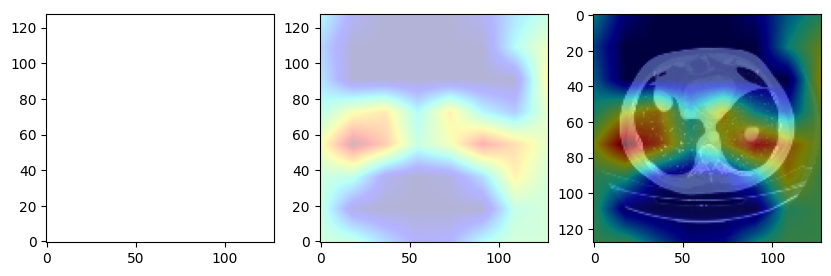

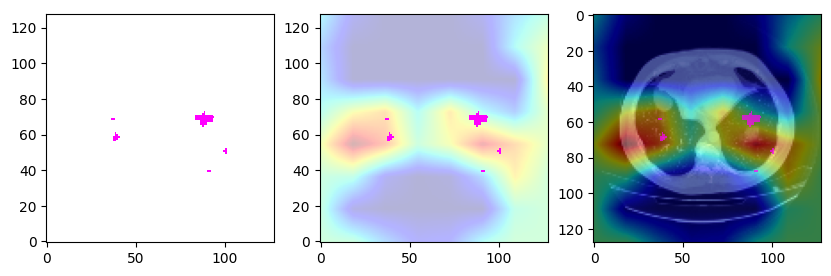

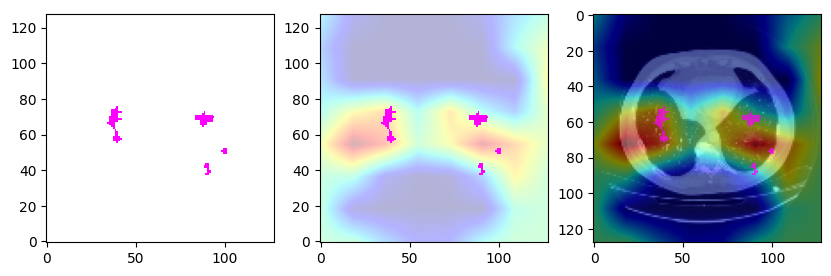

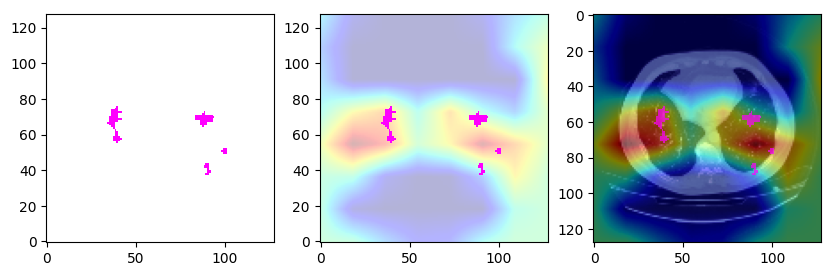

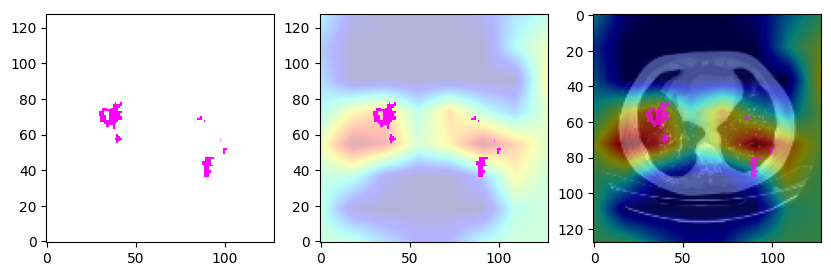

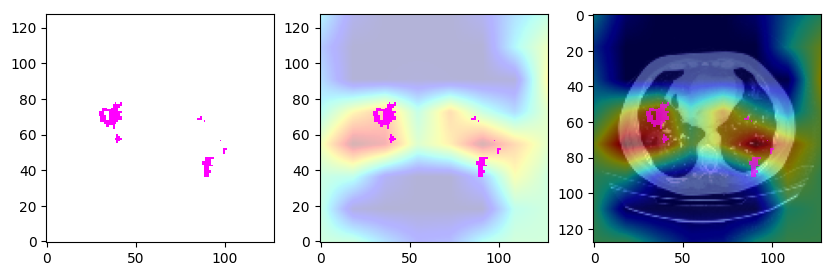

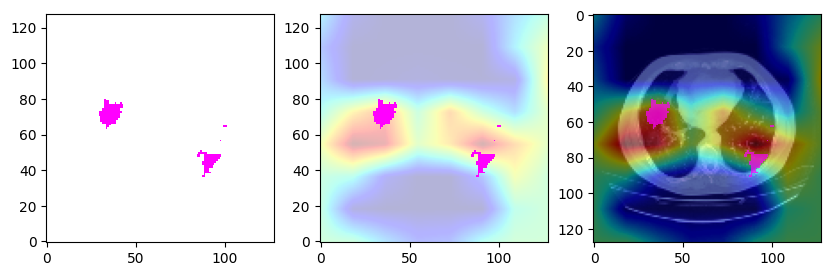

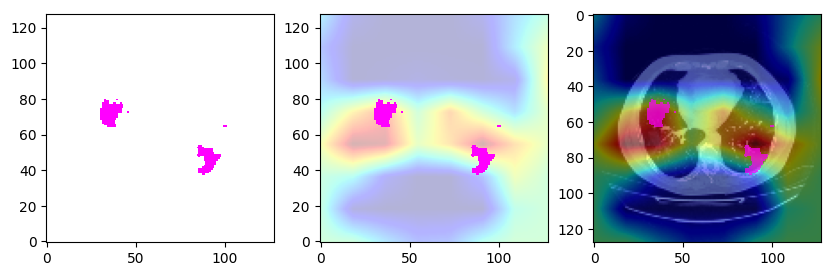

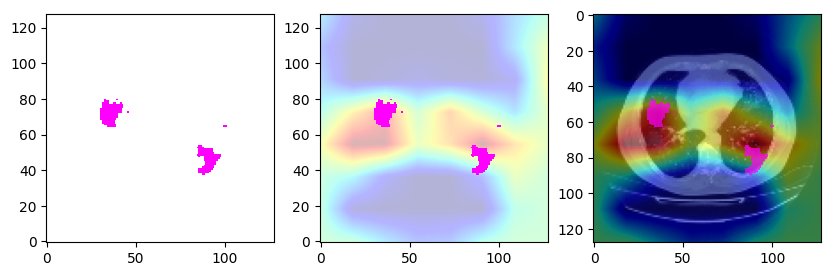

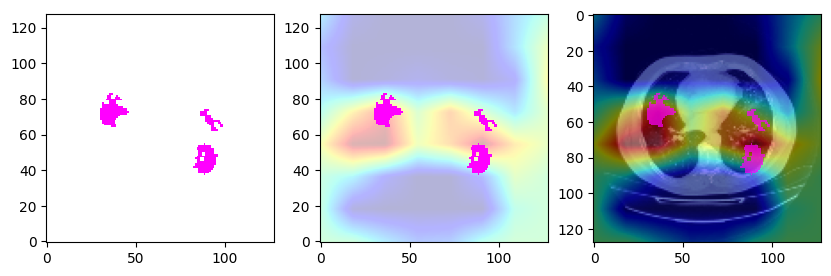

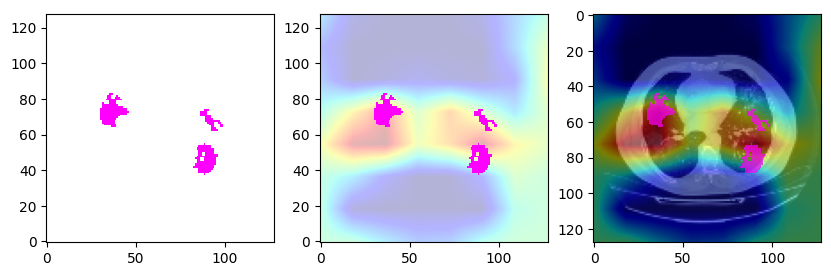

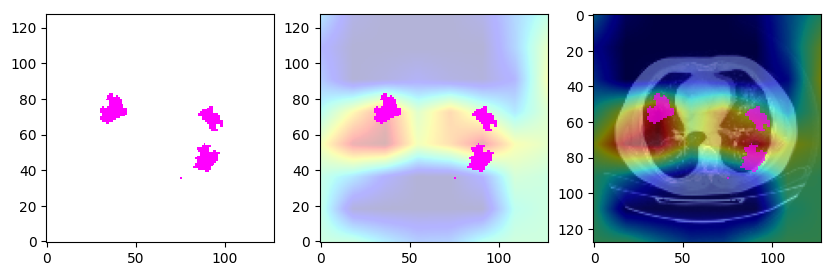

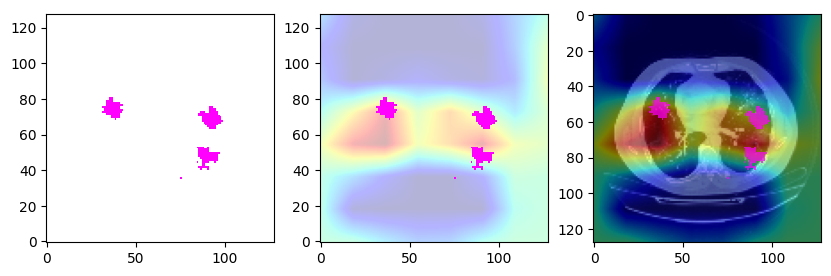

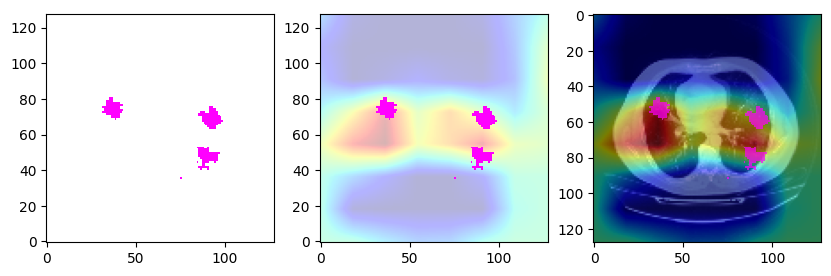

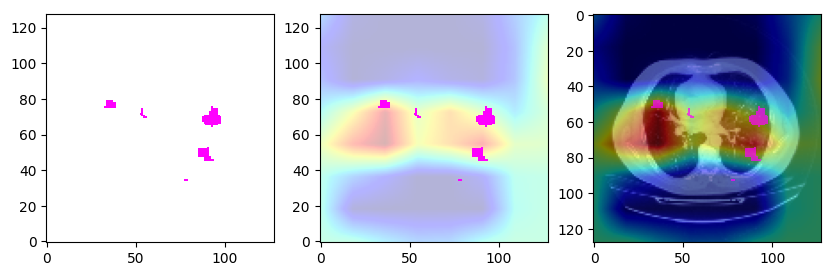

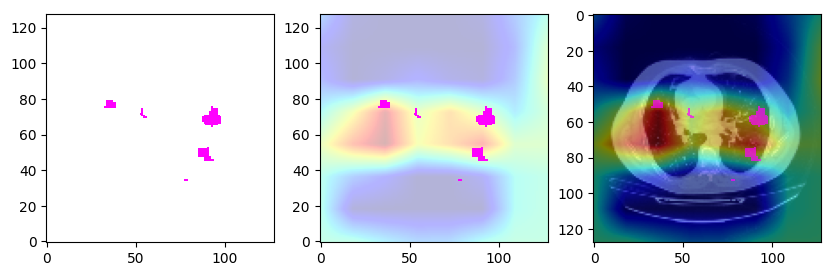

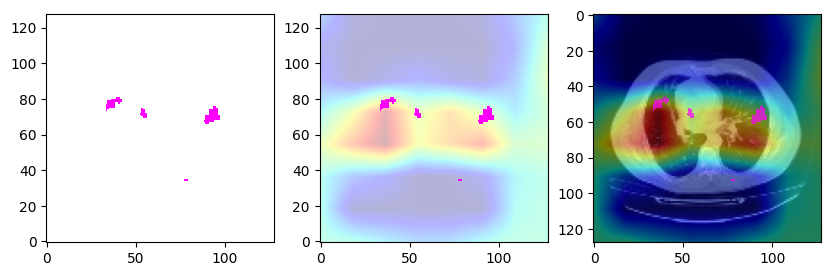

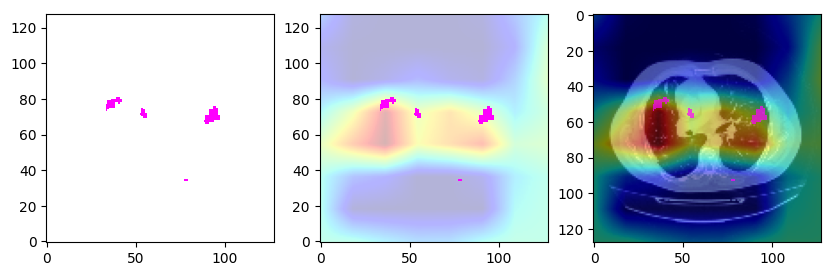

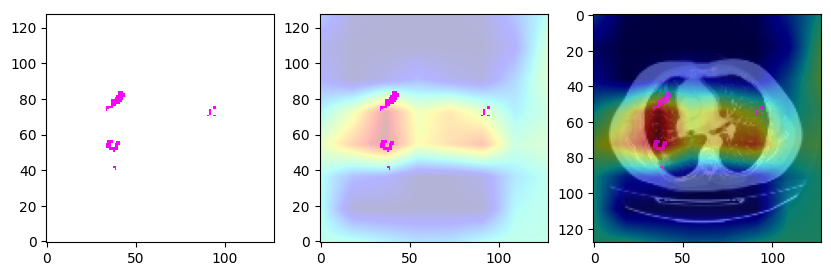

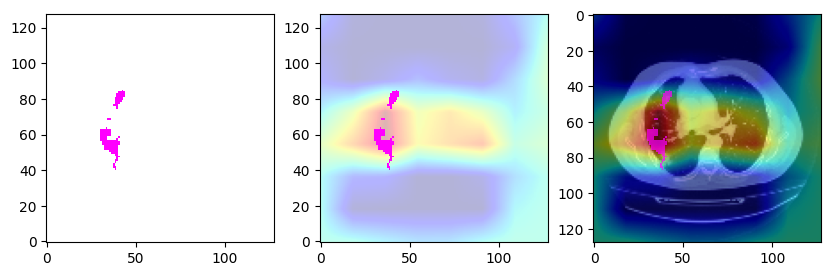

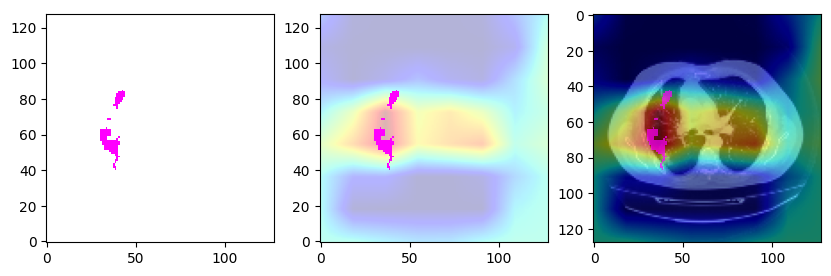

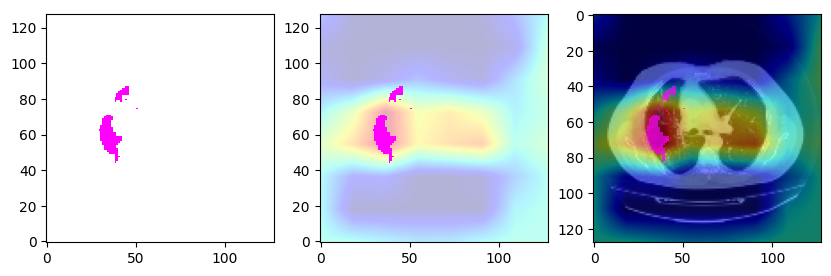

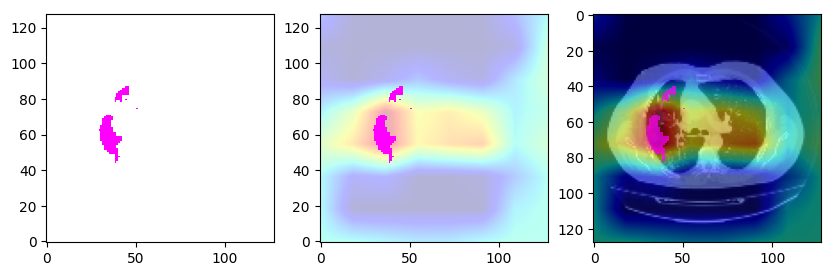

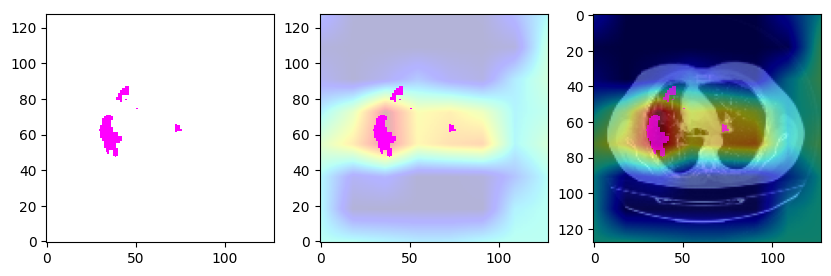

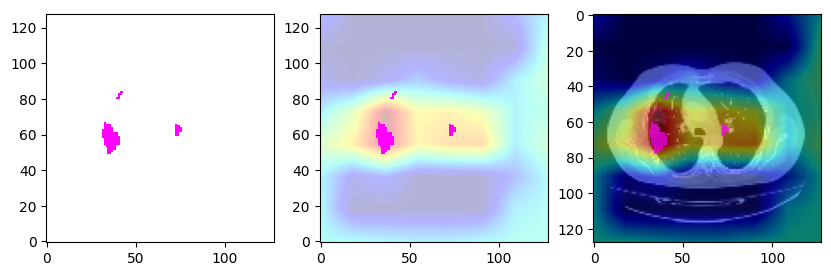

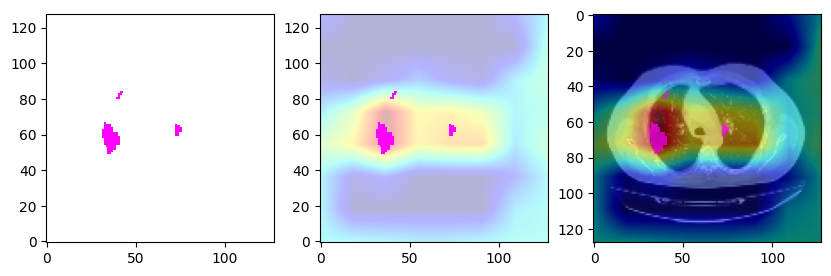

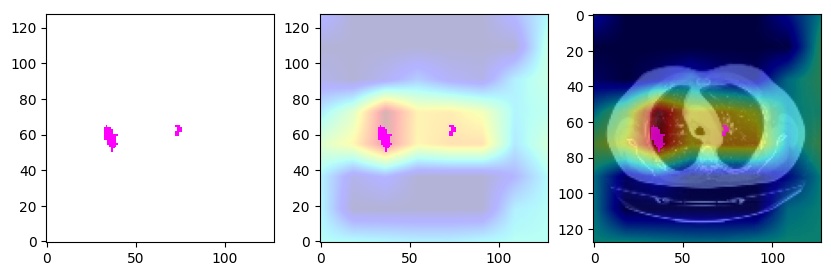

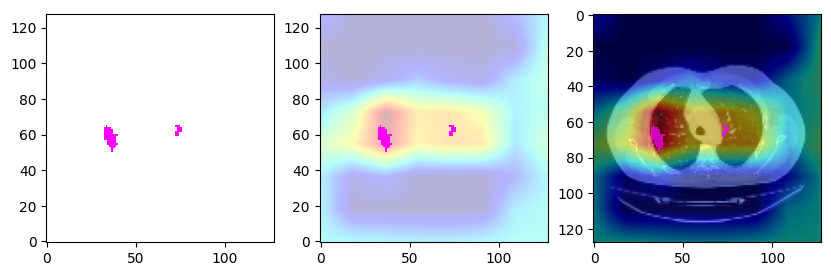

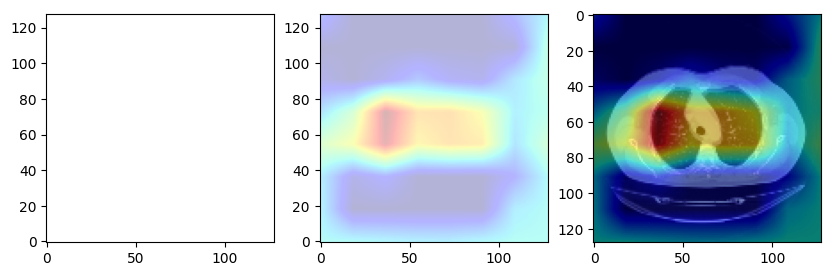

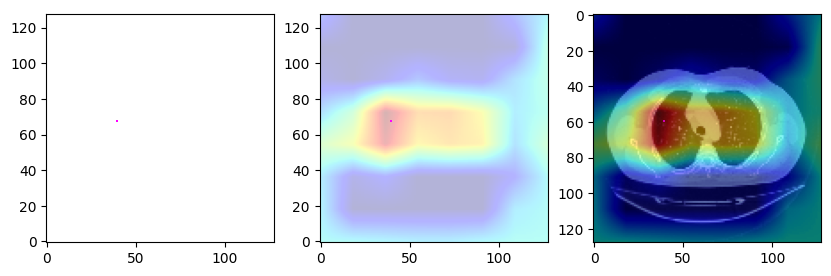

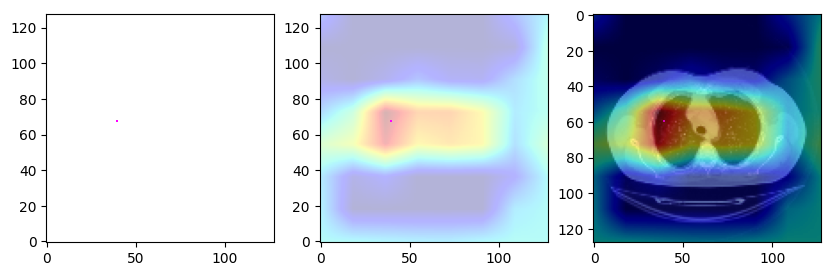

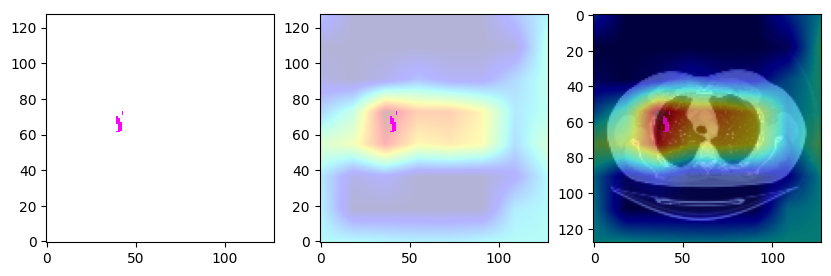

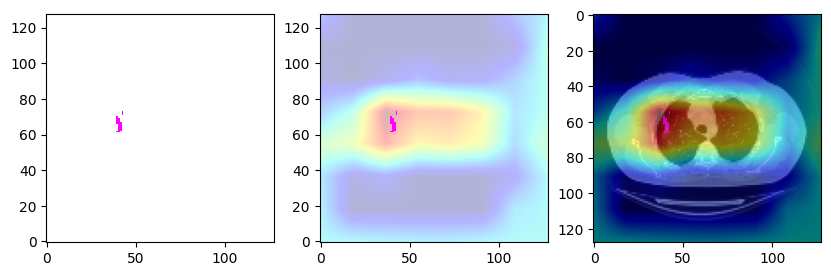

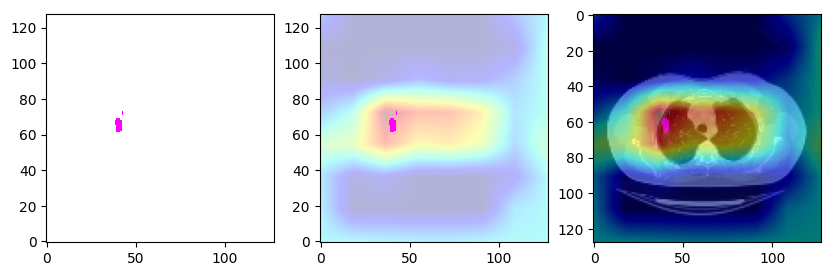

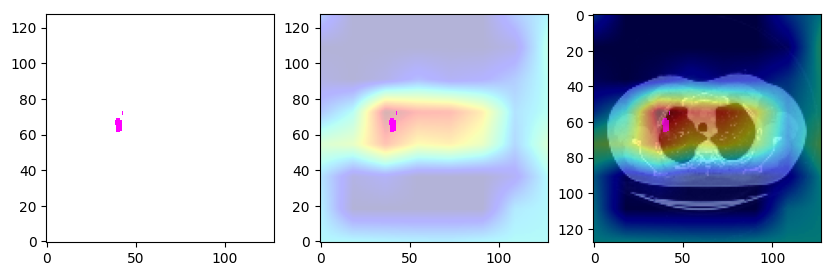

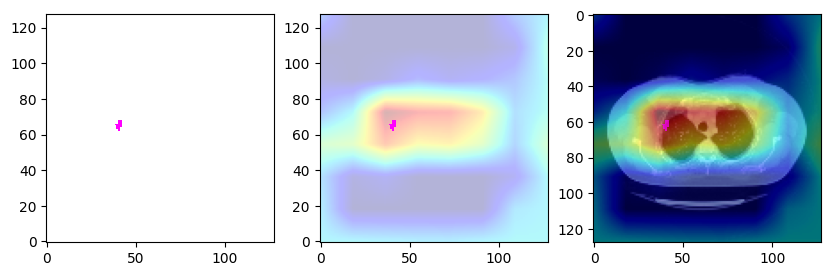

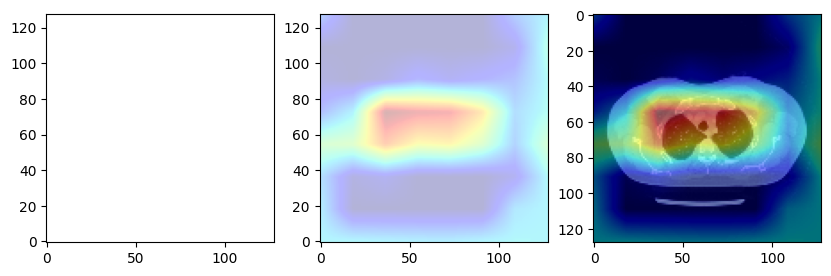

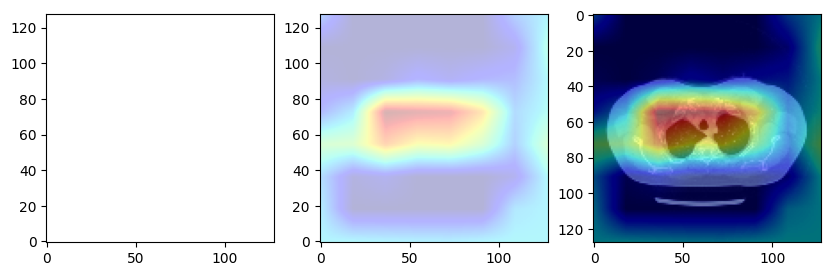

In [14]:
# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]
print(len(indices_list),np.unique(arr))


mask_test = np.where(mask_test == 1, 1, np.nan)  # Set non-1 values to NaN for transparency

for i in range(np.min(np.unique(arr)),np.max(np.unique(arr))+1):
    fig, ax = plt.subplots(1, 3, figsize=(10, 20))

    ax[0].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring', origin='lower')
    
    img3 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, i]), cmap='jet', alpha=0.3, origin='lower')
    img4 = ax[1].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring', origin='lower', extent=img3.get_extent())
    
    img0 = ax[2].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img1 = ax[2].imshow(np.squeeze(resized_heatmap[:, :, i]), cmap='jet', origin='lower', alpha=0.5, extent=img0.get_extent())
    img2 = ax[2].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring',alpha=0.7, origin='lower', extent=img0.get_extent())
    
    

    plt.show()

8092 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]
[ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 1. nan]


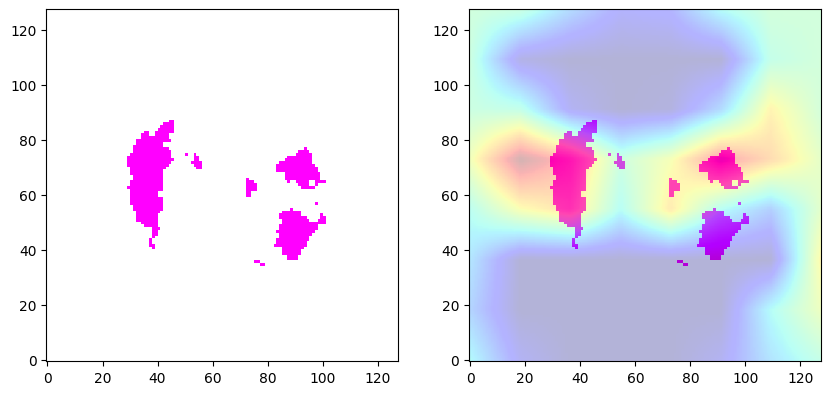

In [15]:
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]
print(len(indices_list),np.unique(arr))

# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)

# mask_test = np.where(mask_test == 1, 1, 0)  # Set non-1 values to NaN for transparency
# print(np.unique(mask_test))
mask_test = np.sum(mask_test, axis=2)
print(np.unique(mask_test))
mask_test = np.where(mask_test > 0, 1, np.nan) 
print(np.unique(mask_test))

# mask_test = np.nan_to_num(mask_test, nan=0)
# print(np.unique(mask_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(mask_test[:, :]),  cmap='spring', origin='lower')
img0 = ax[1].imshow(np.squeeze(mask_test[:, :]),  cmap='spring', origin='lower')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 18]), cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()
